**Research objectives**
  
**General objectives**
  
To develop a Random Forest model that can accurately determine if a transaction is fraudulent
or not.
    
**Specific objectives**
The objectives of this research project are:

**i.To determine if transaction type and period of transaction are crucial in
detecting fraud.**

**ii. To develop a random forest model to detect fraudulent transaction.**

**iii.To evaluate the performance of the developed model using various
performance indicators such as precision , recall, F1-Score, ROC and AUC.**

**iv. To deploy the model in an interactive web application to test the
application in a new environment.**

# Phase 1
# Importing Libraries, Loading and Inspecting the Dataset

**The goal of the codes in the cell below is to load, inspect, and understand the basic properties of the fraud dataset by checking for missing values, duplicates, and data types, setting the stage for subsequent exploratory data analysis, feature engineering, and model building.**

In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

# Load the dataset
df = pd.read_csv('Fraud.csv')

# Display the first few rows of the dataset
df.head()

# Check dataset information
df.info()

# Check for missing values
df.isnull().sum()

# Check for duplicates
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            500000 non-null  int64  
 1   type            500000 non-null  object 
 2   amount          500000 non-null  float64
 3   nameOrig        500000 non-null  object 
 4   oldbalanceOrg   500000 non-null  float64
 5   newbalanceOrig  500000 non-null  float64
 6   nameDest        500000 non-null  object 
 7   oldbalanceDest  500000 non-null  float64
 8   newbalanceDest  500000 non-null  float64
 9   isFraud         500000 non-null  int64  
 10  isFlaggedFraud  500000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 42.0+ MB


0

**This code display the dataset**

In [24]:
df.head()

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   395  TRANSFER  609827.83   C912057903      319610.00            0.00   
1   234   PAYMENT    4474.81  C1016212462      210630.71       206155.91   
2   133   PAYMENT   11274.76  C1300887143           0.00            0.00   
3   162   CASH_IN  112557.06  C1863399248       51813.00       164370.06   
4   236   PAYMENT    5668.73  C1605232029           0.00            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0   C776481928      1520764.37      2154286.47        0               0  
1  M1964375235            0.00            0.00        0               0  
2   M523797020            0.00            0.00        0               0  
3   C619095454      1090345.83       977788.77        0               0  
4   M288148709            0.00            0.00        0               0

**The dataset comprises 500,000 transactions, each described by 11 features, consisting of numerical (integer and float) and categorical (object) data types which require appropriate handling. Crucially, there are no missing values present, streamlining the initial data cleaning process. Furthermore, no duplicated values exist,hence simplifying the data preprocessing step.**

# Phase 2 
## Exploratory Data Analysis and Feature Engineering

**This phase focuses on extracting meaningful insights from the dataset and transforming the data into a format suitable for machine learning. First, the distribution of the target variable, isFraud, is visualized using a pie chart to understand the class imbalance. Then, new features are engineered, including calculating the amount debited/credited to payer/receiver accounts. The script extracts the type of receiver and payer, converts the step column to datetime format to derive hour, day of the week and date. Unnecessary columns, including original account balance columns, identifiers, and the step column itself are dropped to reduce dimensionality and potential noise. The resulting DataFrame now contains a set of potentially more informative features to be used for fraud detection.**

# G1

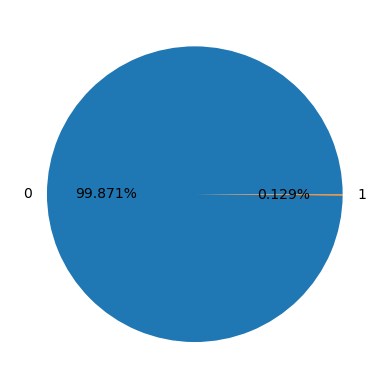

In [25]:
# Visualize the distribution of the target variable 'isFraud'
plt.pie(df["isFraud"].value_counts(), labels=df["isFraud"].unique(), autopct='%1.3f%%')
plt.show()

# Feature engineering: Calculate the amount debited from the payer's account
df["payerdebited"] = df["oldbalanceOrg"] - df["newbalanceOrig"]

# Feature engineering: Calculate the amount credited to the receiver's account
df["recievercredited"] = df["newbalanceDest"] - df["oldbalanceDest"]

# Extract receiver type (Merchant or Customer)
df["reciever_type"] = [i[0:1] for i in df["nameDest"]]

# Extract payer type (Merchant or Customer)
df["payer_type"] = [i[0:1] for i in df["nameOrig"]]

# Convert 'step' to datetime and extract hour, day of the week, and date
df['datetime'] = pd.to_datetime('2025-02-01') + pd.to_timedelta(df['step'], unit='h')
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['date'] = df['datetime'].dt.day

# Drop unnecessary columns
todrop = ["nameDest", "nameOrig", "oldbalanceOrg", "newbalanceOrig", "newbalanceDest", "oldbalanceDest", "payer_type", "step", "datetime", "isFlaggedFraud"]
df.drop(columns=todrop, inplace=True)

**Insights gained**

**1.Significant Class Imbalance** 
    The pie chart visually confirms a substantial class imbalance in the dataset. Specifically, 99.871% of transactions are non-fraudulent (labeled as 0), while only 0.129% are fraudulent (labeled as 1).

**2.Implications for Modeling** 
      This high degree of class imbalance suggests that standard machine learning models might be biased towards the majority   class (non-fraudulent) and perform poorly in detecting fraudulent transactions. Techniques like oversampling, undersampling, or using cost-sensitive algorithms will likely be needed to address this issue during model training and evaluation.

**3.Sampling** 
    The imbalance can be addressed with techniques like oversampling the minority class, undersampling the majority class, or using SMOTE (Synthetic Minority Oversampling Technique).

**4.Algorithm Choice** 
    Algorithms designed to handle imbalanced datasets, like cost-sensitive algorithms, might be more appropriate.

**5. Evaluation Metrics**
    Accuracy alone is not a good metric, better to use precision, recall, F1-score, and AUC-ROC.


# Extracting Patterns from Graphs

# G2

**The main goal of the code is to visualize the distribution of transaction counts across different hours of the day using a bar chart, allowing for the identification of peak and off-peak hours, which might be relevant for fraud detection or operational insights.**

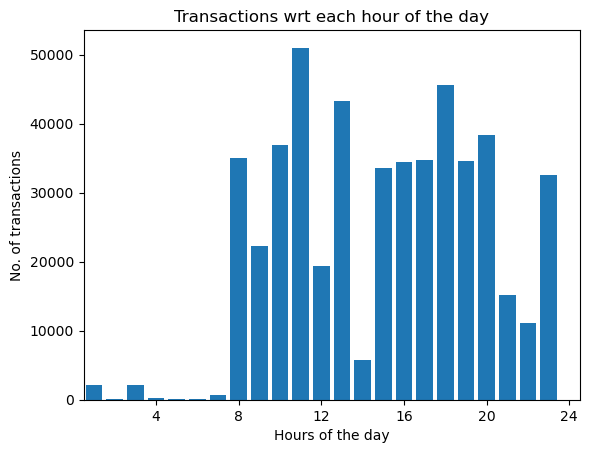

In [26]:
plt.bar(df['hour'].unique(), df['hour'].value_counts())
plt.xlim(0.5, 24.5)
plt.xticks(range(4, 25, 4))
plt.xlabel("Hours of the day")
plt.ylabel("No. of transactions")
plt.title("Transactions wrt each hour of the day")
plt.show()

**Insights gained**

**Transaction Volume Patterns:**
    The graph reveals clear patterns in transaction volume throughout the day. The highest number of transactions appears to occur between 10:00 AM and 8:00 PM, with noticeable peaks during the midday and late afternoon/early evening hours. The lowest activity occurs during the early morning hours between 12:00 AM and 6:00 AM.

**Potential Anomalies:** Deviations from the typical transaction patterns could signal potentially fraudulent activities. If there's an unexpected surge in transactions during low-activity hours, it may warrant further investigation.


# G3

**The main goal of the code block is to visualize the distribution of transaction counts across the days of the week.**

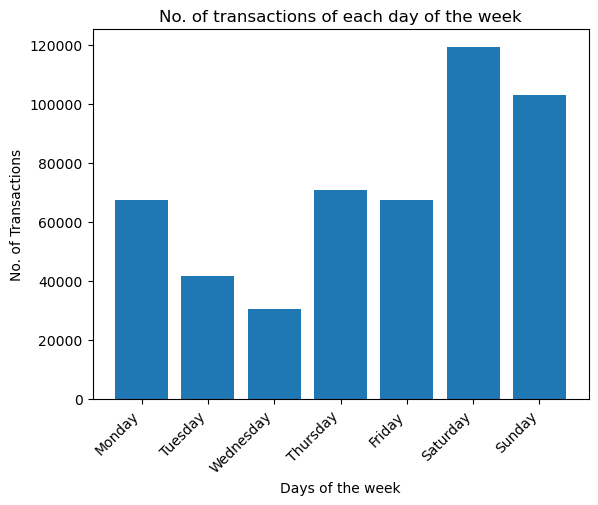

In [27]:
# Map day_of_week integers to day names
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Get the counts for each day of the week, sorted by day (0 to 6)
day_counts = df['day_of_week'].value_counts().sort_index()

# Plot the bar chart
plt.bar(day_names, day_counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Days of the week")
plt.ylabel("No. of Transactions")
plt.title("No. of transactions of each day of the week")
plt.show()

**Insights gained**

**1. Transaction Volume by Day** The graph indicates that Sunday has the highest number of transactions, which is unusual compared to typical weekly patterns where weekdays often have higher transaction volumes. This anomaly suggests that Sunday might be a critical day for monitoring.

**2. Peak Transaction Day** Sunday stands out as the day with the highest transaction volume. This could imply a higher risk of fraudulent activities due to the increased number of transactions. Fraud detection systems should be particularly vigilant on this day.

**3. Low Transaction Days** Monday and other weekdays have lower transaction volumes compared to Sunday. This might suggest a lower risk of fraud on these days, but consistent monitoring is still essential as fraudsters might exploit less busy days.

**The main goal of code in the cell below is to determine and display the frequency of each unique value within the "type" column of a Pandas DataFrame (df).**

In [28]:
df["type"].value_counts()

type
CASH_OUT    175911
PAYMENT     169397
CASH_IN     109496
TRANSFER     41845
DEBIT         3351
Name: count, dtype: int64

**Insight gained**

**The data reveals that the system is primarily used for cash withdrawals (CASH_OUT) and payments (PAYMENT), with a good amount of cash deposits (CASH_IN). Transfers are less common, and debits are relatively rare.**

# G4

**This code creates a pie chart showing the percentage breakdown of each type of transaction in the dataset. This is a way to quickly understand the relative distribution of transaction types.**

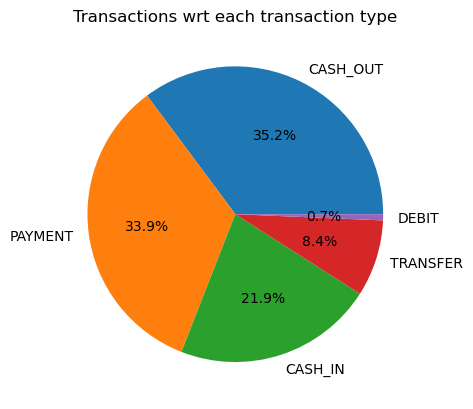

In [29]:
plt.pie(df["type"].value_counts(), labels=df["type"].value_counts().index,autopct='%1.1f%%')
plt.title("Transactions wrt each transaction type")
plt.show()

# G5

**This code aims to discover if there are specific hours or transaction types that are more prone to fraudulent activities, allowing for a better understanding and potentially mitigation of fraudulent behavior. The heatmap provides a clear visual representation of these patterns, making it easy to identify high-risk periods and transaction types.**

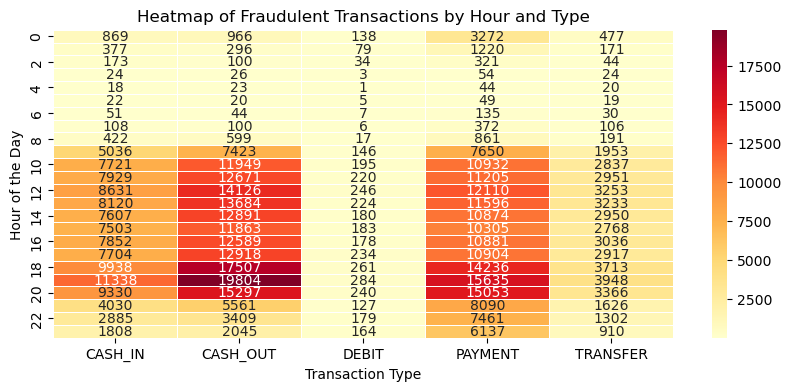

In [30]:
# Create a pivot table for fraudulent transactions
fraud_pivot = df.pivot_table(index='hour', columns='type', values='isFraud', aggfunc='count', fill_value=0)

# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(fraud_pivot, cmap='YlOrRd', annot=True, fmt='d', linewidths=0.5)
plt.xlabel("Transaction Type")
plt.ylabel("Hour of the Day")
plt.title("Heatmap of Fraudulent Transactions by Hour and Type")
plt.show()

**Insights gained**

**1.Transaction Types and Fraud Frequency**

        CASH_OUT and TRANSFER transactions have the highest frequency of fraudulent activities, as indicated by the significantly higher numbers in these categories.

        PAYMENT and CASH_IN transactions also show notable fraudulent activities but to a lesser extent compared to CASH_OUT and TRANSFER.

        DEBIT transactions have the lowest frequency of fraudulent activities.

**2. Hourly Patterns**

        Fraudulent activities peak during specific hours of the day. The highest numbers of fraudulent transactions occur around midday and early afternoon (hours 10 to 15).

        There is a noticeable increase in fraudulent activities starting from hour 9, peaking around hour 13, and then gradually decreasing.

        Late-night and early-morning hours (hours 0 to 8) show relatively lower fraudulent activities.

**3. Peak Fraud Hours**

     The hours with the highest fraudulent activities are around 13:00 to 15:00, with CASH_OUT and TRANSFER transactions being the most affected.

        Hour 13 shows the highest number of fraudulent transactions across all types, particularly for CASH_OUT and TRANSFER.

**4. Implications for Fraud Detection**

        Enhanced monitoring and detection mechanisms should be implemented during peak hours (10:00 to 15:00) to mitigate the risk of fraudulent activities.

        Special attention should be given to CASH_OUT and TRANSFER transactions, as they are the most susceptible to fraud.

        Although DEBIT transactions have the lowest fraud frequency, continuous monitoring is still necessary to detect any unusual patterns.

# G6

 **The goal is to identify at which hours of the day fraudulent transactions are most common, providing insights into when preventative measures might be most effective.**

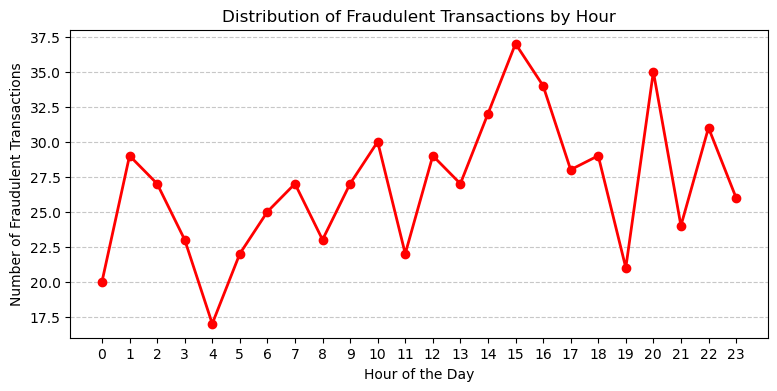

In [31]:
# Filter fraudulent transactions
fraud_df = df[df['isFraud'] == 1]

# Count fraudulent transactions by hour
fraud_by_hour = fraud_df['hour'].value_counts().sort_index()  # Corrected line

# Plot the distribution of fraudulent transactions by hour (line plot)
plt.figure(figsize=(9, 4))
plt.plot(fraud_by_hour.index, fraud_by_hour.values, marker='o', color='red', linestyle='-', linewidth=2)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Distribution of Fraudulent Transactions by Hour")
plt.xticks(range(0, 24))  # Show all hours on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Insight gained**

**1. Hourly Fraud Trends**

        The graph shows the number of fraudulent transactions occurring at each hour of the day.

        Fraudulent activities are not evenly distributed throughout the day; there are noticeable peaks and troughs.

**2. Peak Fraud Hours**

        The highest number of fraudulent transactions occurs around midday to early afternoon, specifically between 12:00 (noon) and 15:00 (3 PM).

        This period shows a significant spike in fraudulent activities, indicating that fraudsters are more active during these hours.

**3. Low Fraud Hours**

        The lowest number of fraudulent transactions occurs during the early morning hours, particularly between 4:00 AM and 7:00 AM.

        This suggests that fraudulent activities are less frequent during these hours, possibly due to lower overall transaction volumes.

**4.Gradual Increase and Decrease**

        Fraudulent transactions start to increase gradually from the early morning (around 8:00 AM) and reach their peak around midday.

        After the peak, the number of fraudulent transactions gradually decreases throughout the afternoon and evening, with another slight increase in the late evening (around 9:00 PM to 11:00 PM).

**Implications for Fraud Detection**

        Enhanced monitoring and fraud detection mechanisms should be prioritized during the peak hours (12:00 PM to 3:00 PM) when the risk of fraudulent activities is highest.

        Although the early morning hours show lower fraud activity, continuous monitoring is still essential to detect any unusual patterns or anomalies.

        The slight increase in fraudulent activities during the late evening suggests that vigilance should be maintained throughout the day, with a focus on the identified peak periods.

# G7

 **This code provides a visualization to compare the number of fraudulent transactions for each transaction type within a given hour, helping to identify which transaction types are most susceptible to fraud during different times of the day.**

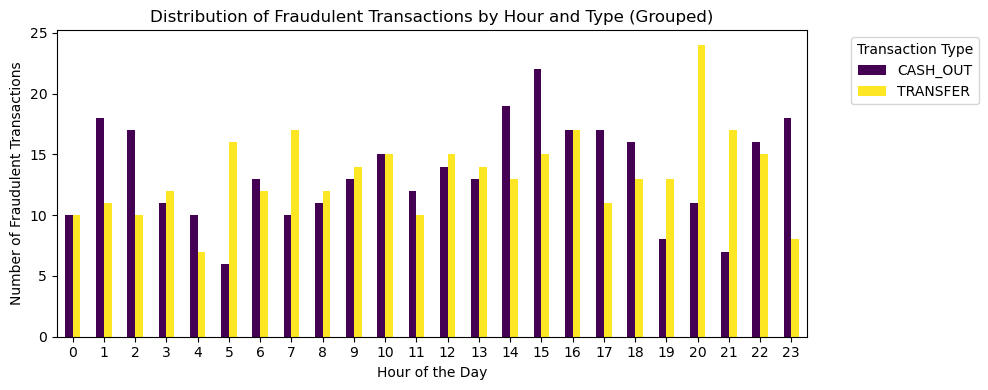

In [32]:
# Filter fraudulent transactions
fraud_df = df[df['isFraud'] == 1]

# Group fraudulent transactions by hour and transaction type
fraud_by_hour_type = fraud_df.groupby(['hour', 'type']).size().unstack(fill_value=0)

# Plot the distribution of fraudulent transactions by hour and type (grouped bar chart)
fraud_by_hour_type.plot(kind='bar', figsize=(10, 4), colormap='viridis')  # stacked=False is the default

plt.xlabel("Hour of the Day")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Distribution of Fraudulent Transactions by Hour and Type (Grouped)")
plt.xticks(rotation=0)  # Keep x-axis labels horizontal for readability
plt.legend(title="Transaction Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**The grouped bar chart allows for a direct comparison of fraudulent CASH_OUT and TRANSFER transactions by hour, confirming the higher overall fraud rate for CASH_OUT and revealing a clearer picture of its peak hours, while also showing that TRANSFER fraud is distributed relatively evenly throughout the day.**

# Phase 3
# Balancing the Dataset

**Class Imbalance Mitigation**

The primary goal is to mitigate the class imbalance issue where legitimate (non-fraudulent) transactions significantly outnumber fraudulent transactions. This imbalance can lead to biased machine learning models that perform poorly in detecting fraud.

**Balanced Dataset Creation**

By downsampling the majority class (non-fraudulent transactions), the code aims to create a balanced dataset where the number of non-fraudulent transactions is equal to the number of fraudulent transactions. This balance allows the model to learn equally from both classes.

**Improved Model Performance**

The ultimate goal is to improve the model's ability to detect fraudulent transactions by ensuring it is not biased towards the majority class.

**Reasoning Behind the Approach**

**Inherent Imbalance in Fraud Data**

Fraud datasets are typically highly imbalanced, with a small percentage of transactions being fraudulent.

This imbalance can cause models to be biased towards the majority class, leading to high accuracy but poor fraud detection performance.

**Downsampling as a Solution**

**Reduction of Majority Class** 

Downsampling reduces the number of non-fraudulent transactions to match the number of fraudulent transactions.

**Balanced Learning** 

This creates a balanced dataset, enabling the model to learn patterns from both classes equally, which is crucial for effective fraud detection.

**Tradeoff Consideration**

**Dataset Size Reduction**

While downsampling improves class balance, it reduces the overall dataset size, potentially discarding useful information from the majority class.

**Practical Compromise** 

Despite this tradeoff, downsampling is a practical approach to enhance the model's performance in detecting the minority class (fraudulent transactions).

In [33]:
# Separate the dataset into fraud and non-fraud transactions
fraud = df[df['isFraud'] == 1]
non_fraud = df[df['isFraud'] == 0]

# Downsample the majority class (non-fraud) to match the size of the minority class (fraud)
non_fraud_downsampled = non_fraud.sample(n=len(fraud), random_state=42)

# Combine the downsampled majority class with the minority class
balanced_df = pd.concat([fraud, non_fraud_downsampled])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# G8

**This code shows the distribution of classes after balancing the dataset**

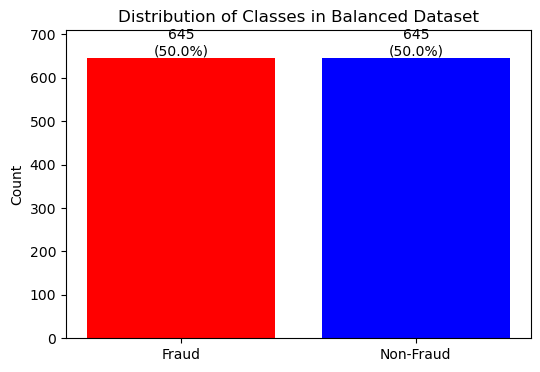

In [34]:
# Count the number of fraud and non-fraud transactions in the balanced dataset
fraud_count = len(balanced_df[balanced_df['isFraud'] == 1])
non_fraud_count = len(balanced_df[balanced_df['isFraud'] == 0])

# Create categories and counts
categories = ['Fraud', 'Non-Fraud']
counts = [fraud_count, non_fraud_count]

# Create bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(categories, counts, color=['red', 'blue'])

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height}\n({height/sum(counts):.1%})',
            ha='center', va='bottom')

# Add title and labels
plt.title('Distribution of Classes in Balanced Dataset')
plt.ylabel('Count')
plt.ylim(0, max(counts) * 1.1)  # Add some space for the labels

# Show plot
plt.show()

**The bar graph indicates that the downsampling process has achieved the goal of creating a balanced dataset with an equal number of fraudulent and non-fraudulent transactions. This balance is essential for improving the model's performance in detecting fraudulent activities, even though it comes at the cost of reducing the overall dataset size.**

# Phase 4
# Detecting and Handling Outliers

**The main aim of the code is to identify, count, and filter outliers in a balanced dataset to improve data quality for machine learning or statistical analysis. Outliers, which are data points that deviate significantly from the rest, can negatively impact model performance or skew results. Using the Interquartile Range (IQR) method, the code calculates and counts outliers across numeric columns, then creates a mask to remove rows containing these extreme values. This ensures the cleaned dataset (balanced_df_cleaned) contains only data within acceptable bounds, enhancing reliability and accuracy for further analysis or model training.**

In [35]:
# Function to count the number of outliers
def outlier_count(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    upwhisk = Q3 + (IQR * 1.5)
    lowhisk = Q1 - (IQR * 1.5)
    outlier_count = ((data > upwhisk) | (data < lowhisk)).sum()
    return outlier_count

# Count outliers in numeric columns only
outliers = 0
numeric_columns = balanced_df.select_dtypes(include=[np.number]).columns  # Select only numeric columns
for col in numeric_columns:
    outliers += outlier_count(balanced_df[col])
print(f'No of Outliers: {outliers}')

# Create a mask to filter out outliers
outlier_mask = pd.Series(True, index=balanced_df.index)  # Initialize mask with all True values

for col in numeric_columns:
    Q1 = balanced_df[col].quantile(0.25)
    Q3 = balanced_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Update the mask to keep only rows within the bounds for each column
    outlier_mask &= ((balanced_df[col] >= lower_bound) & (balanced_df[col] <= upper_bound))

# Filter the DataFrame to remove outliers
balanced_df_cleaned = balanced_df[outlier_mask]

# Check the shape of the cleaned DataFrame
print(f"Original shape: {balanced_df.shape}")
print(f"Cleaned shape: {balanced_df_cleaned.shape}")

No of Outliers: 595
Original shape: (1290, 9)
Cleaned shape: (995, 9)


**The above output indicates that 595 outliers were identified across the numeric columns of the original balanced dataset, which initially had 1,290 rows and 9 columns. After filtering out these outliers using the IQR method, the cleaned dataset (balanced_df_cleaned) contains 995 rows and retains the same 9 columns. This reduction in rows demonstrates that approximately 295 rows were removed due to containing outlier values, resulting in a dataset with improved data quality and reduced influence from extreme values, making it more suitable for reliable analysis or model training.**

# Phase 5
# Splitting and Training Model

**This code is to prepare and train a machine learning model, specifically a Random Forest classifier, for fraud detection using a balanced dataset. The code first encodes categorical variables into numerical values using LabelEncoder to make the data suitable for the model. It then splits the dataset into training and testing sets, ensuring a 20% test size. The Random Forest model is trained on the training data, and predictions are made on the test set. Additionally, the code calculates the probability of fraud for each transaction. This process aims to build a robust model capable of accurately identifying fraudulent transactions based on the provided features.**

In [36]:
# Encode categorical variables
cat_cols = [col for col in balanced_df.columns if balanced_df[col].dtype == "object"]
encoder = LabelEncoder()
encoded_df = balanced_df.copy()
mappings = {}

for col in cat_cols:
    encoded_df[col] = encoder.fit_transform(balanced_df[col])
    mappings[col] = pd.Series(encoder.transform(encoder.classes_), index=encoder.classes_)

# Split the dataset into training and testing sets
x = encoded_df.drop(columns=["isFraud", "date", "reciever_type", "hour", "day_of_week"])
y = encoded_df['isFraud']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

# Predictions
y_pred = rf_model.predict(x_test)
y_proba = rf_model.predict_proba(x_test)[:, 1]



**The code generates and prints mappings for each categorical column in the dataset, showing the relationship between the original categorical values and their corresponding encoded numerical values. These mappings are stored in a dictionary called mappings, where each key represents a categorical column name, and the value is a pandas.Series that pairs the original categories with their encoded integers. This output provides a clear reference for understanding how categorical data was transformed into numerical format, which is essential for interpreting model predictions or reversing the encoding process if needed.**

In [37]:
# Print the mappings for each categorical column
for col, mapping in mappings.items():
    print(f"Mapping for column '{col}':")
    print(mapping)
    print("\n")

Mapping for column 'type':
CASH_IN     0
CASH_OUT    1
DEBIT       2
PAYMENT     3
TRANSFER    4
dtype: int64


Mapping for column 'reciever_type':
C    0
M    1
dtype: int64




**The output displays the numerical encoding of categorical values for the columns 'type' and 'reciever_type', where each original category is mapped to a unique integer. For 'type', the mappings are CASH_IN → 0, CASH_OUT → 1, DEBIT → 2, PAYMENT → 3, and TRANSFER → 4, while for 'reciever_type', the mappings are Customer(C) → 0 and Merchant(M) → 1.**

# Phase 6
# Performance Evaluation

**The main aim of this code is to evaluate the performance of the trained Random Forest model in predicting fraudulent transactions. It achieves this by generating a classification report and a confusion matrix, which provide detailed insights into the model's accuracy, precision, recall, F1-score, and its ability to correctly classify fraudulent and non-fraudulent transactions. These metrics help assess the model's effectiveness in detecting fraud and identify potential areas for improvement.**

In [38]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       136
           1       0.94      0.96      0.95       122

    accuracy                           0.95       258
   macro avg       0.95      0.95      0.95       258
weighted avg       0.95      0.95      0.95       258

Confusion Matrix:
[[129   7]
 [  5 117]]


**The output provides a classification report and a confusion matrix, which evaluate the performance of the Random Forest model in predicting fraudulent transactions.**
**Classification Report**

**Precision**

        For class 0 (non-fraud): 0.96 — Out of all transactions predicted as non-fraud, 96% were correct.

        For class 1 (fraud): 0.94 — Out of all transactions predicted as fraud, 94% were correct.

**Recall**

        For class 0: 0.95 — The model correctly identified 95% of the actual non-fraud transactions.

        For class 1: 0.96 — The model correctly identified 96% of the actual fraud transactions.

**F1-Score**

        For class 0: 0.96 — A balanced measure of precision and recall for non-fraud transactions.

        For class 1: 0.95 — A balanced measure of precision and recall for fraud transactions.

**Support**

        Class 0: 136 — There are 136 actual non-fraud transactions in the test set.

        Class 1: 122 — There are 122 actual fraud transactions in the test set.

**Accuracy**

        The overall accuracy of the model is 0.95, meaning it correctly predicted 95% of all transactions.

**Averages**

        Macro Avg: The average of precision, recall, and F1-score for both classes, without considering class imbalance.

        Weighted Avg: The average of precision, recall, and F1-score, weighted by the number of samples in each class.

**Confusion Matrix**

**The confusion matrix provides a breakdown of the model's predictions**

    True Positives (TP): 117 — The model correctly predicted 117 fraud transactions.

    True Negatives (TN): 129 — The model correctly predicted 129 non-fraud transactions.

    False Positives (FP): 7 — The model incorrectly predicted 7 non-fraud transactions as fraud.

    False Negatives (FN): 5 — The model incorrectly predicted 5 fraud transactions as non-fraud.

# G9

**This code is to visually represent the confusion matrix as a heatmap, making it easier to interpret the model's performance in distinguishing between fraudulent and non-fraudulent transactions by highlighting correct predictions (true positives and true negatives) and errors (false positives and false negatives).**

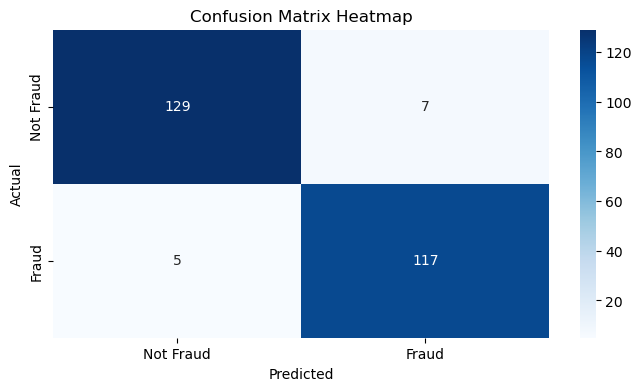

In [39]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Not Fraud", "Fraud"], 
            yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()


**The output values in the confusion matrix heatmap represent the model's classification results: True Negatives (129) indicate the model correctly identified 129 transactions as "Not Fraud," while False Positives (7) show it incorrectly classified 7 "Not Fraud" transactions as "Fraud." On the other hand, False Negatives (5) represent the model incorrectly classifying 5 "Fraud" transactions as "Not Fraud," and True Positives (117) reflect the model correctly identifying 117 transactions as "Fraud." These values provide a clear breakdown of the model's accuracy and errors, highlighting its performance in distinguishing between fraudulent and non-fraudulent transactions.**

# G10

**The code is to evaluate the model's performance using the ROC Curve (with AUC score) and Precision-Recall Curve, which visually and quantitatively assess the model's ability to distinguish between fraudulent and non-fraudulent transactions based on its predictive probabilities.** 

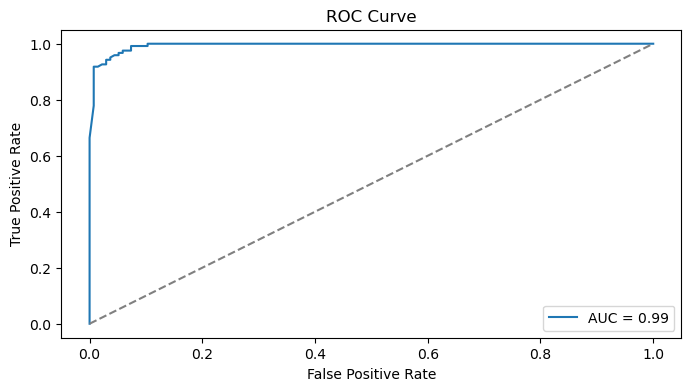

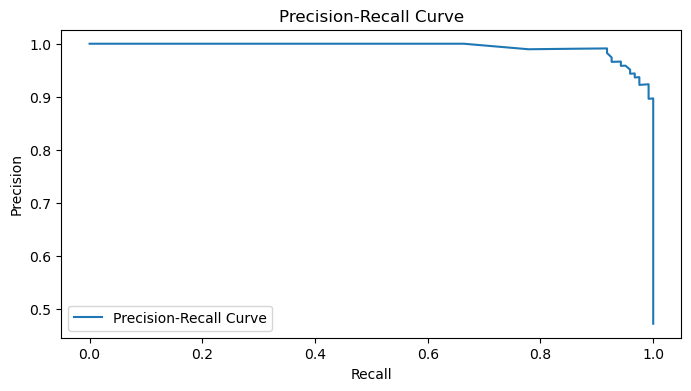

In [40]:
# ROC Curve and AUC Score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 4))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

**The ROC Curve graph above shows the model's performance with an AUC score of 0.99, indicating excellent ability to distinguish between fraudulent and non-fraudulent transactions, as the curve closely follows the top-left corner, representing high true positive rates and low false positive rates. The Precision-Recall Curve image illustrates the trade-off between precision and recall, with the curve's shape and position reflecting the model's effectiveness in maintaining high precision while achieving high recall, which is crucial for imbalanced datasets like fraud detection. Together, these visualizations confirm the model's strong predictive performance and reliability in identifying fraud.**

# Phase 7
# Feature Importance

**The expectation of this code is to provide insights into the features used for training the Random Forest model and their relative importance in predicting fraudulent transactions.**

In [41]:
# Print the features used for training
print("Features used for training the model:")
print(x.columns.tolist())

# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print("\nFeature Importance Scores:")
print(feature_importance_df)

Features used for training the model:
['type', 'amount', 'payerdebited', 'recievercredited']

Feature Importance Scores:
            Feature  Importance
2      payerdebited    0.568513
1            amount    0.169496
3  recievercredited    0.138632
0              type    0.123358


**The output indicates the features used for training the model, which include 'type', 'amount', 'payerdebited', and 'recievercredited'. The feature importance scores reveal how much each feature contributed to the model's predictions, with 'payerdebited' being the most influential at 0.568513, followed by 'amount' at 0.169496, 'recievercredited' at 0.138632, and 'type' at 0.123358. This ranking helps identify the key drivers of the model's decision-making process, with 'payerdebited' playing the most significant role in detecting fraudulent transactions.**

# Phase 8
# Save and Load the Model

**The main aim of this code is to save the trained Random Forest model (rf_model) to a file using the pickle module, ensuring that the model can be stored and reused later without retraining, and then to load the saved model back into memory to verify that it can be successfully retrieved and used for future predictions or evaluations. This process facilitates model persistence and deployment in real-world applications.**

In [42]:
import pickle

# Save the trained model
with open("model.pkl", "wb") as file:
    pickle.dump(rf_model, file)

print("Model saved successfully!")

# Load the saved model from the file
with open("model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!


**The main aim of this code is to test the loaded Random Forest model (loaded_model) by creating a sample input dataset, making predictions on it, and displaying both the predicted classes and their associated probabilities. This process verifies that the model functions correctly after being saved and loaded, and demonstrates its ability to classify new transactions as fraudulent or non-fraudulent based on the provided features (type, amount, payerdebited, and recievercredited).**

In [43]:
# Create a sample input for testing
sample_data = {
    'type': [4, 4, 4],  # Different transaction types
    'amount': [1000.0, 50000.0, 200.0],  # Different amounts
    'payerdebited': [500.0, 25000.0, 100.0],  # Different debited amounts
    'recievercredited': [500.0, 25000.0, 100.0]  # Different credited amounts
}

# Convert the sample data into a DataFrame
sample_df = pd.DataFrame(sample_data)

# Ensure the columns are in the correct order (same as during training)
sample_df = sample_df[['type', 'amount', 'payerdebited', 'recievercredited']]

# Make predictions using the loaded model
predictions = loaded_model.predict(sample_df)

# Display the predictions
print("Predictions:", predictions)

# If you want to see the predicted probabilities (for classification)
if hasattr(loaded_model, "predict_proba"):
    probabilities = loaded_model.predict_proba(sample_df)
    print("Predicted Probabilities:", probabilities)

Predictions: [1 1 1]
Predicted Probabilities: [[0.44 0.56]
 [0.19 0.81]
 [0.41 0.59]]


**The output provides the predictions and predicted probabilities for the sample input data:**

**Predictions: [1 1 1]**

        The model predicts that all three sample transactions are classified as 1 (fraudulent).

**Predicted Probabilities**

        For each transaction, the model provides the probabilities of belonging to class 0 (non-fraudulent) and class 1 (fraudulent).

        The first transaction has a 44% probability of being non-fraudulent and a 56% probability of being fraudulent.

        The second transaction has a 19% probability of being non-fraudulent and an 81% probability of being fraudulent.

        The third transaction has a 41% probability of being non-fraudulent and a 59% probability of being fraudulent.

**This output demonstrates the model's confidence in classifying the transactions as fraudulent, with higher probabilities assigned to class 1 for all samples.**

**The saved model, deployed using the Flask framework, allows for real-time testing of the fraud detection system in a new environment. When provided with sample input data, the model outputs predictions and predicted probabilities:**